## Описание проекта:


Наша задача вместе с отделом маркетинга запустить и проанализировать AB тесты и принять решение по результатам теста


Описание данных:

hypothesis
 - Hypothesis — краткое описание гипотезы;
 - Reach — охват пользователей по 10-балльной шкале;
 - Impact — влияние на пользователей по 10-балльной шкале;
 - Confidence — уверенность в гипотезе по 10-балльной шкале;
 - Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

orders

 - transactionId — идентификатор заказа;
 - visitorId — идентификатор пользователя, совершившего заказ;
 - date — дата, когда был совершён заказ;
 - revenue — выручка заказа;
 - group — группа A/B-теста, в которую попал заказ.

visitors
 - date — дата;
 - group — группа A/B-теста;
 - visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
pd.options.display.max_colwidth = 210

In [2]:
hypothesis, orders, visitors = (
    pd.read_csv('hypothesis.csv'),  # гипотезы
    pd.read_csv('orders.csv'),  # заказы
    pd.read_csv('visitors.csv'),  # пользователи
)

In [3]:
hypothesis.columns = hypothesis.columns.str.lower().str.replace(' ', '_')

In [4]:
def first_look(df):
    print('.'*10,'Первые 5 строк','.'*10)
    display(df.head())
    print('')
    print('')
    print('.'*10,'Тип данных','.'*10)
    print('')
    df.info()
    print('')
    print('')
    print('.'*10,'Пропуски','.'*10)
    print('')
    count = 0
    for column in df.columns:
        if df[column].isna().sum()>0:
            print(column,'-',df[column].isna().sum(), 'пропусков')
            print(f'Доля пропусков в таблице составляет {(df[column].isna().sum())/len(df[column]):.1%}')
            count =+ 1
    if count == 0:
        print('Пропусков нет')
    print('')
    print('')
    print('.'*10,'Дубликаты','.'*10)
    if df.duplicated().sum()>0:
        print('Дубликатов:', df.duplicated().sum())
    else:
        print('Дубликатов нет')

In [5]:
first_look(hypothesis)

.......... Первые 5 строк ..........


,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1




.......... Тип данных ..........

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


.......... Пропуски ..........

Пропусков нет


.......... Дубликаты ..........
Дубликатов нет


In [6]:
first_look(orders)

.......... Первые 5 строк ..........


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B




.......... Тип данных ..........

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


.......... Пропуски ..........

Пропусков нет


.......... Дубликаты ..........
Дубликатов нет


In [7]:
first_look(visitors)

.......... Первые 5 строк ..........


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756




.......... Тип данных ..........

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


.......... Пропуски ..........

Пропусков нет


.......... Дубликаты ..........
Дубликатов нет


In [8]:
print(orders['date'].dtype,
      visitors['date'].dtype)

object object


In [9]:
# преобразование данных о времени
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
print(orders['date'].dtype,
      visitors['date'].dtype)

datetime64[ns] datetime64[ns]


Для целей А/В тестирования важно проверить, что пользователи из разных групп не пересекаются

In [10]:
# найдем этих "двойных" пользователей и запишем в переменную a_b_users
a_b_users = np.intersect1d(orders.query('group == "A"')['visitorId'].unique(),
                                  orders.query('group == "B"')['visitorId'].unique()) 

In [11]:
# проверим количество
len(a_b_users)

58

In [12]:
orders['visitorId'].nunique()

1031

In [13]:
orders = orders[~orders['visitorId'].isin(a_b_users)]

In [14]:
orders['visitorId'].nunique()

973

## Приоритизация гипотез

Чтобы максимизировать ожидаемое улучшение ключевых метрик бизнеса, приоритизируем сформулированные гипотезы

### Framework ICE

In [15]:
display(hypothesis)
hypothesis['ICE'] = hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']
hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


### Вывод

Наиболее перспективны гипотезы 8, 0, 7 и 6

### Framework RICE

In [16]:
hypothesis['RICE'] = hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']
hypothesis[['hypothesis','RICE']].sort_values(by='RICE',ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [17]:
display(hypothesis[['hypothesis','ICE','RICE']].sort_values(by=['ICE', 'RICE'], ascending=False). \
                      reset_index(drop=False).style. \
                      format({'ICE': '{:.2f}', 'RICE' : '{:.2f}'}). \
                      bar(subset=['RICE', 'ICE'], 
                          align='mid', 
                          color = ['lightblue'], 
                          vmax=hypothesis['RICE'].max()). \
                      set_properties(**{'text-align':'center'}, subset=['ICE', 'RICE']))

,index,hypothesis,ICE,RICE
0,8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.20
1,0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.00
2,7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.00
3,6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.00
4,2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.00
5,1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.00
6,5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.00
7,3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.00
8,4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.00


### Вывод

И снова наиболее перспективны гипотезы: 0, 7 и 6. Однако на первом месте гипотеза 7. Гипотеза 8, лидирующая в ICE, в лидеры не попала из-за маленького параметра Reach. Зато гипотеза номер 2 поднялась с пятого на второе место, потому что её Reach равен 8.

Кроме силы гипотезы нужно учитывать то, как много пользователей она затронет. Номер 7 и сильная и имеет хороший охват 

## Анализ A/B-теста

### График кумулятивной выручки по группам

In [18]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()
datesGroups.head()

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


In [19]:
# получаем агрегированные кумулятивные по дням данные о заказах
#orders.loc[orders.duplicated(['transactionId','group']),'transactionId'] = np.nan
orders_agg = orders.groupby(['date','group']).agg(
            orders = ('transactionId', 'nunique'),
            buyers = ('visitorId', 'nunique'),
            revenue = ('revenue', 'sum')
            ).sort_values(by=['date','group']).groupby('group').cumsum().reset_index()

In [20]:
orders_agg.head()

,date,group,orders,buyers,revenue
0,2019-08-01,A,23,19,142779
1,2019-08-01,B,17,17,59758
2,2019-08-02,A,42,37,234381
3,2019-08-02,B,40,39,221801
4,2019-08-03,A,66,61,346854


In [21]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['visitorId', 'orders']
ordersByUsers.sort_values(by='orders')

,visitorId,orders
0,5114589,1
636,2758621772,1
637,2761566146,1
638,2763027084,1
639,2771749575,1
...,...,...
138,611059232,3
908,3967698036,3
632,2742574263,3
890,3908431265,3


Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина:

In [22]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
    lambda x:visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
        'date':'max',
        'group':'max',
        'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [23]:
visitorsAggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [24]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = orders_agg.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,37,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,61,346854,1845


Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

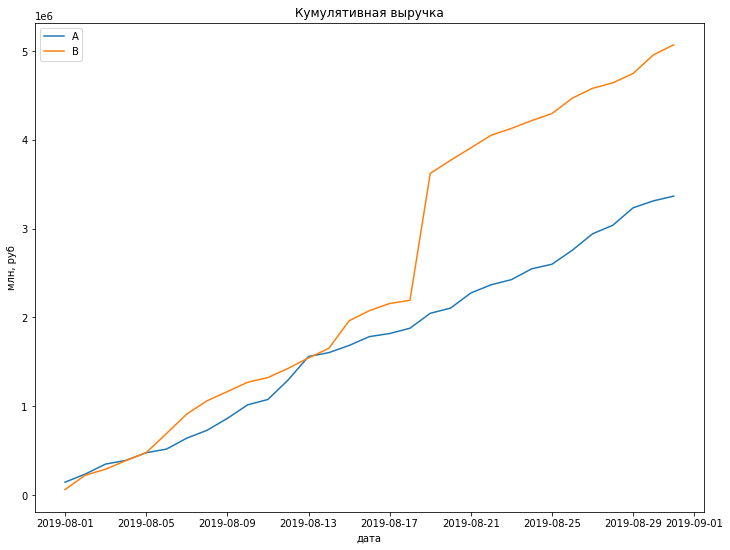

In [42]:

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.rcParams["figure.figsize"] = (12,9)

plt.title("Кумулятивная выручка")
plt.xlabel("дата")
plt.ylabel("млн, руб")
plt.legend()

plt.show()

### Вывод

 - Выручка почти равномерно увеличивается в течение всего теста.
 - Однако графики выручки группы B в одной из точек резко растут. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. При заключительном анализе их нужно удалить

### График кумулятивного среднего чека по группам

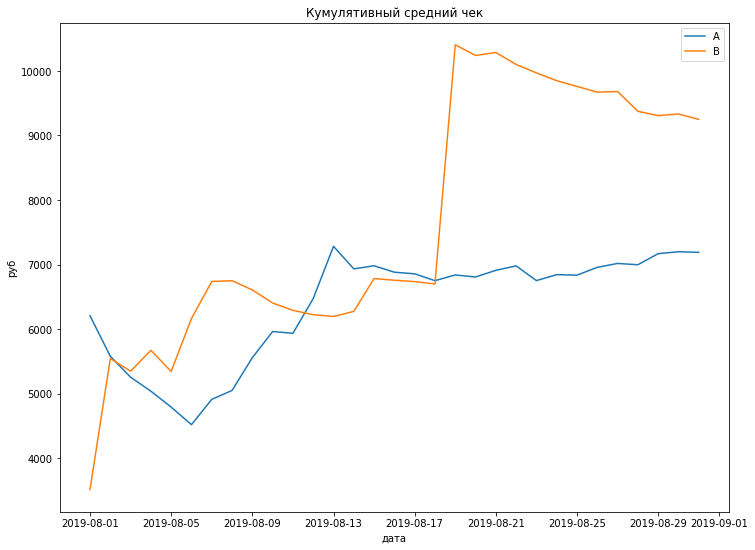

In [26]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title("Кумулятивный средний чек")
plt.xlabel("дата")
plt.ylabel("руб")
plt.legend()
plt.show()

### Вывод

 - Средний чек по группам продолжает колебаться. Скорее всего принимать решение по этой метрике рано.
 - Возможно, в группу B во второй половине теста попали крупные заказы (резкий всплеск на графике). Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

### График относительного изменения кумулятивного среднего чека группы B к группе A

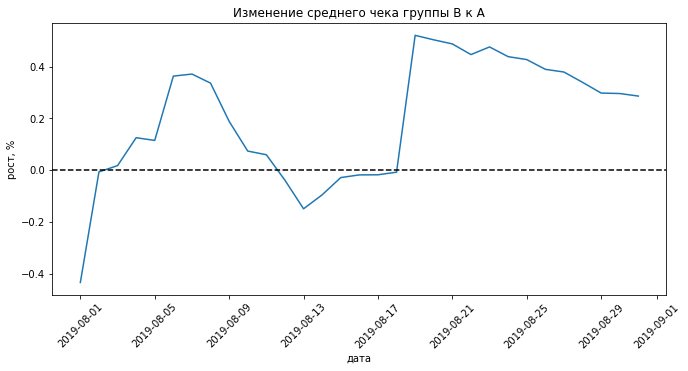

In [27]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(11,5))
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.title("Изменение среднего чека группы B к A")
plt.xlabel("дата")
plt.ylabel("рост, %")
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation = 45)
plt.show()

### Вывод

 - Результаты теста значительно и резко менялись в несколько дат
 - Резкие скачки графика в нескольких местах свидетельсвуют о больших вбросах

### График кумулятивной конверсии по группам

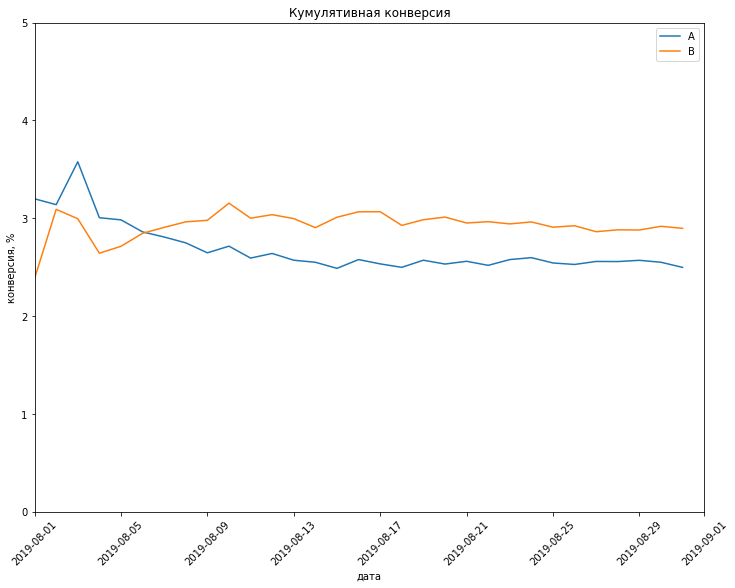

In [28]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']*100

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.title("Кумулятивная конверсия")
plt.xlabel("дата")
plt.ylabel("конверсия, %")

plt.legend()

plt.xticks(rotation = 45)

# задаем масштаб осей
plt.axis([dt.datetime(2019,8,1),dt.datetime(2019,9,1), 0, 5])
plt.show()

### Вывод

 - В начале теста сегмент А имел большую конверсию, но постепенно сегмент В вырвался вперёд, выровнялся и зафиксировался около одного значения, большего значения группы A, которое просело и тоже выровнялось
 - Абсолютное значение колебания в начале теста и в конце не слишком большое: от 2,5%  до 3,5%

### График относительного изменения кумулятивной конверсии группы B к группе A

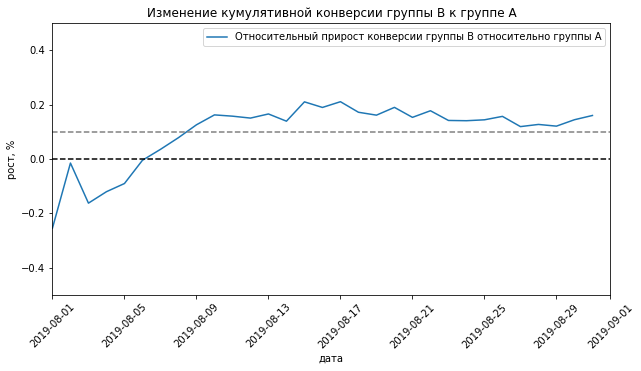

In [29]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(10,5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.title("Изменение кумулятивной конверсии группы B к группе A")
plt.xlabel("дата")
plt.ylabel("рост, %")
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.10, color='grey', linestyle='--')
plt.axis([dt.datetime(2019,8,1),dt.datetime(2019,9,1),-0.5, 0.5])

plt.xticks(rotation = 45)

plt.show()

**Вывод**

Почти с самого начала теста группа B лучше группы A. Либо она станет лучше, либо зафиксируется на значении около 10% лучше группы  А.

Отметим небольшую стабилизацию результатов теста после 21.08.2019

Проанализируем аномалии, а потом сделаем выводы

### Точечный график количества заказов по пользователям

      visitorId group  orders
908  3967698036     A       3
55    249864742     B       3
478  2108163459     A       3
687  2988190573     A       3
890  3908431265     A       3
138   611059232     A       3
632  2742574263     B       3
157   678354126     A       2
323  1404560065     B       2
452  1985475298     B       2


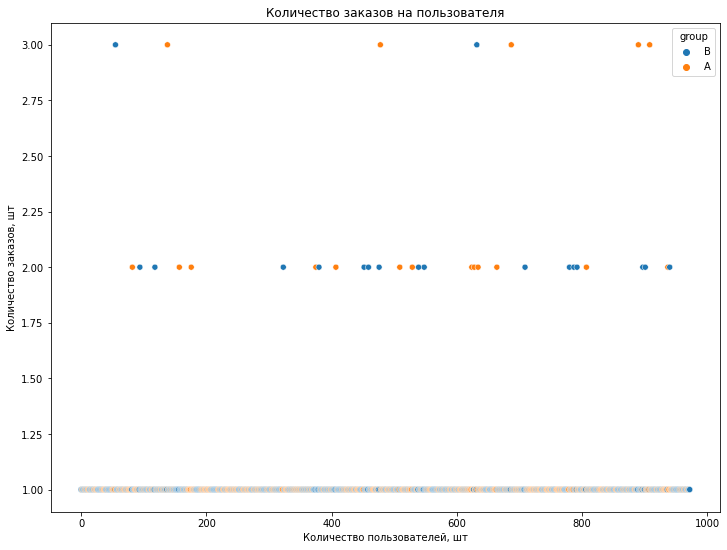

In [30]:
ordersByUsers = (
    orders.groupby(['visitorId', 'group'], as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['visitorId', 'group', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))
sns.scatterplot(data = ordersByUsers, x=x_values, y=ordersByUsers['orders'], hue="group")

plt.title("Количество заказов на пользователя")
plt.xlabel("Количество пользователей, шт")
plt.ylabel("Количество заказов, шт")
plt.show()

### Вывод

В основном пользователи делают 1-2 заказа. Людей, делающих более двух заказов, немного, но является ли это аномалией? Чтобы ответить на вопрос, посчитаем процентили.

### 95-й и 99-й перцентили количества заказов на пользователя

In [31]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


**Вывод**

не более 1% пользователей сделало больше 2 заказов. Выберем 2 заказа на одного пользователя за нижнюю границу и отсеим аномальных пользолвателей по ней. 

### Точечный график стоимостей заказов

Text(0, 0.5, 'Стоимость, руб')

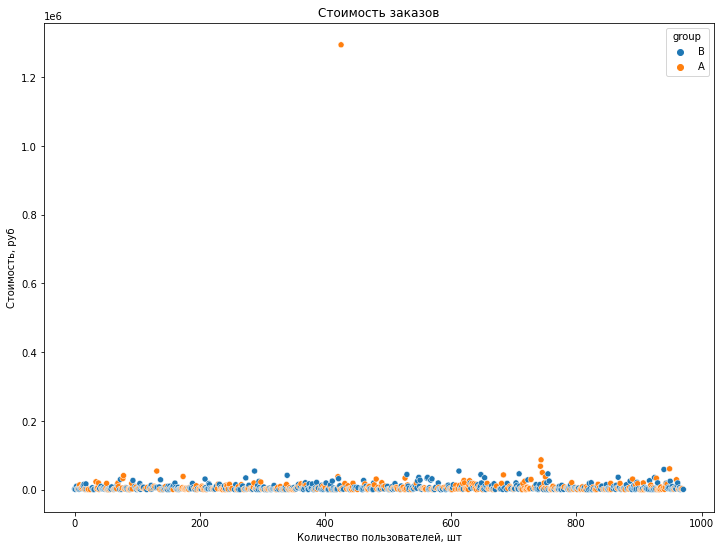

In [32]:
x_values = pd.Series(range(0, len(orders['revenue'])))

sns.scatterplot(data = ordersByUsers, x=x_values, y=orders['revenue'], hue="group")
plt.title("Стоимость заказов")
plt.xlabel("Количество пользователей, шт")
plt.ylabel("Стоимость, руб")


**Вывод**

Заказы стоимостью более 1 200 000 руб. выглядят аномально. Есть вбросы около 200 000 руб заказов, дороже 50 000 руб тоже не очень много

### 95-й и 99-й перцентили стоимости заказов

In [33]:
print(np.percentile(orders['revenue'],[95,99]))

[26785. 53904.]


**Вывод**

Не более, чем у 5% заказов чек дороже 27 000. И не больше, чем у 1% заказов - дороже 54 000. В качестве границы выберем 27 000 руб за заказ

### Статистическая значимость различий в конверсии между группами по «сырым» данным.

Сформулируем гипотезы. 

H0: различий в среднем количестве заказов между группами нет. 

H1: различия в среднем между группами есть.

In [34]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5)) 

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              23           142779              17   
1 2019-08-02              19            91602              23   
2 2019-08-03              24           112473              14   
3 2019-08-04              11            41176              14   
4 2019-08-05              22            86383              21   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0            59758                  23               142779   
1           162043                  42               234381   
2            67049                  66               346854   
3            96890                  77               388030   
4            89908                  99               474413   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  17                59758               719   
1                  40               221801               619   
2                  54               28

In [35]:
#для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

#пользователям из разных групп будет соответствовать количество заказов
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

pvalue=stats.mannwhitneyu(sampleA, sampleB)[1]


alpha = 0.05

print('p-значение: ', pvalue)
if pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Отвергнуть нулевую гипотезу нельзя')
print('Относительный прирост среднего числа заказов группы B: '"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-значение:  0.011018084110014696
Отвергаем нулевую гипотезу
Относительный прирост среднего числа заказов группы B: 0.160


### Вывод

По «сырым» данным нельзя точно сказать, что различий в среднем числе заказов групп A и B нет.

Первое число — p-value = 0.011 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Относительный проигрыш группы B равен 16%

### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

H0: различий в среднем чеке между группами нет. 

H1: различия в среднем чеке между группами есть.

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов.

In [36]:
pvalue=stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]


alpha = 0.05

print('p-значение: ', pvalue)
if pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Отвергнуть нулевую гипотезу нельзя')
print('Относительный прирост среднего чека группы B: ''{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-значение:  0.8294908998149533
Отвергнуть нулевую гипотезу нельзя
Относительный прирост среднего чека группы B: 0.287


### Вывод

p-value = 0.829 больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, не отвергаем. Средний чек группы B значительно выше среднего чека группы A.

### Cтатистическая значимость различий в конверсии между группами по «очищенным» данным

найденные 95-й и 99-й перцентили средних чеков равны 26 785 и 53 904 рублям. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 1 и 2 заказа на пользователя.

Примем за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ дороже 27 000 рублей. Так мы уберём % пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 27 000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers.

In [37]:
minorder=2
minrevenue=27000

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > minorder]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > minorder]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > minrevenue]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: visitorId, dtype: int64
58


Всего 58 аномальных пользователей.
Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [38]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [39]:
pvalue=stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]


alpha = 0.05

print('p-значение: ', pvalue)
if pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Отвергнуть нулевую гипотезу нельзя')
print('Относительный прирост среднего числа заказов группы B: ''{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-значение:  0.01235203801772639
Отвергаем нулевую гипотезу
Относительный прирост среднего числа заказов группы B: 0.182


Результаты по среднему количеству заказов практически не изменились.

### Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [40]:
pvalue=stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]


alpha = 0.05

print('p-значение: ', pvalue)
if pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Отвергнуть нулевую гипотезу нельзя')
print('Относительный прирост среднего чека группы B: ''{0:.3f}'.format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1)
     )

p-значение:  0.6458964038091206
Отвергнуть нулевую гипотезу нельзя
Относительный прирост среднего чека группы B: -0.048


P-value уменьшился, но и разница между сегментами изменилась с +28 до -5%

### Вывод

 - Есть статистически значимое различие по конверсии между группами и по «сырым», и по данным после фильтрации аномалий;
 - Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
 - График различия конверсии между группами сообщает, что почти с самого начала теста группа B лучше группы A.
 - График различия среднего чека колеблется: он-то и позволил вам найти аномалии. Сделать из этого графика определённые выводы нельзя.

Продолжать тест смысла нет: группа B статистически значимо лучше группы A только в одной из метрики после удаления аномалий ситуация не изменилась